In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc
import math
import re

from tqdm import tqdm
from collections import Counter

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore')

# change to path
PATH='/content/drive/My Drive/Colab Notebooks/grab/'
os.chdir(PATH)

In [0]:
PATH_LABELS = PATH + 'safety/labels'
PATH_FEATURES = PATH + 'safety/features'

## Read in
Start working from the aggregated dataframe `agg_df`.

In [4]:
train_df = pd.read_pickle(f'{PATH_FEATURES}/sample_new_103.pkl')

train_df.head()

,bookingID,Accuracy_min,Accuracy_max,Accuracy_mean,Accuracy_std,Bearing_min,Bearing_max,Bearing_mean,Bearing_std,acceleration_x_min,acceleration_x_max,acceleration_x_mean,acceleration_x_std,acceleration_y_min,acceleration_y_max,acceleration_y_mean,acceleration_y_std,acceleration_z_min,acceleration_z_max,acceleration_z_mean,acceleration_z_std,gyro_x_min,gyro_x_max,gyro_x_mean,gyro_x_std,gyro_y_min,gyro_y_max,gyro_y_mean,gyro_y_std,gyro_z_min,gyro_z_max,gyro_z_mean,gyro_z_std,second_min,second_max,second_mean,second_std,Speed_min,Speed_max,Speed_mean,...,acceleration_x_so_min,acceleration_x_so_max,acceleration_x_sign_change,acceleration_y_fo_mean,acceleration_y_fo_min,acceleration_y_fo_max,acceleration_y_so_mean,acceleration_y_so_min,acceleration_y_so_max,acceleration_y_sign_change,acceleration_z_fo_mean,acceleration_z_fo_min,acceleration_z_fo_max,acceleration_z_so_mean,acceleration_z_so_min,acceleration_z_so_max,acceleration_z_sign_change,gyro_x_fo_mean,gyro_x_fo_min,gyro_x_fo_max,gyro_x_so_mean,gyro_x_so_min,gyro_x_so_max,gyro_x_sign_change,gyro_y_fo_mean,gyro_y_fo_min,gyro_y_fo_max,gyro_y_so_mean,gyro_y_so_min,gyro_y_so_max,gyro_y_sign_change,gyro_z_fo_mean,gyro_z_fo_min,gyro_z_fo_max,gyro_z_so_mean,gyro_z_so_min,gyro_z_so_max,gyro_z_sign_change,vc,label
0,0,4.0,48.000,10.165339,3.855898,0.037464,359.979767,176.526099,129.231351,-4.692294,4.782614,-0.711264,0.928022,-12.764703,-6.119916,-9.613822,0.639934,-6.251807,2.318857,-1.619658,1.141266,-0.392537,0.438371,0.003328,0.065954,-0.609930,0.469724,-0.006118,0.100225,-0.731892,0.372807,-0.004188,0.063685,0.0,1589.0,903.526892,533.745097,-1.0,22.946083,8.994822,...,-10.184308,8.453427,278.0,0.000324,-3.953137,3.903342,0.000934,-7.856479,5.524164,0.0,0.001660,-4.960413,6.332556,0.002131,-9.415692,10.856174,144.0,0.000062,-0.470277,0.446838,-0.000139,-0.878883,0.792117,503.0,0.000133,-0.609200,0.632817,-0.000037,-0.982114,1.163994,519.0,-0.000056,-0.731597,0.860446,-0.000050,-1.010095,1.592042,489.0,1004,0
1,1,3.0,7.709,3.718763,0.597933,0.000000,337.000000,124.198590,89.861236,-5.352994,3.813341,-0.525406,0.744157,6.623425,12.536156,9.532086,0.533915,-5.355455,1.481293,-2.198999,0.854271,-0.125367,0.126536,-0.002467,0.027740,-0.678183,0.470837,-0.007540,0.091699,-0.121265,0.235131,0.000405,0.033838,0.0,1034.0,581.175088,289.339367,-1.0,21.882141,7.881588,...,-8.524900,8.847361,180.0,-0.000785,-3.323172,3.170564,0.000634,-6.294559,6.425989,0.0,0.001054,-5.032708,5.158748,0.002540,-9.591842,7.498774,24.0,-0.000050,-0.179333,0.121126,-0.000053,-0.246702,0.291941,428.0,0.000008,-0.717767,0.596711,-0.000281,-0.782274,1.275626,433.0,-0.000069,-0.216438,0.275204,-0.000048,-0.484521,0.283110,415.0,851,1
2,2,3.0,8.000,3.930626,1.117354,1.000000,354.000000,173.794872,119.316520,-2.971295,1.956122,0.306786,0.756589,7.941810,13.333716,9.843183,0.505693,-3.282551,2.312870,0.139347,1.020021,-0.155218,0.282162,0.006458,0.053903,-0.462000,0.431695,-0.012861,0.117321,-0.125907,0.255884,0.002597,0.036215,0.0,825.0,339.441026,356.319445,0.0,9.360483,3.157213,...,-5.013611,7.108602,80.0,0.001592,-3.490852,3.031151,0.003449,-6.522003,4.005621,0.0,0.004134,-5.375147,4.326454,0.006488,-7.043957,8.842057,88.0,-0.000356,-0.277944,0.298713,-0.000529,-0.576657,0.397062,98.0,0.001603,-0.638354,0.507018,-0.000608,-1.034806,0.967000,101.0,-0.000482,-0.276111,0.258396,-0.000215,-0.534507,0.324369,113.0,195,1
3,4,10.0,10.000,10.000000,0.000000,2.271227,353.855377,151.807013,71.273774,-2.866458,2.019635,-0.365117,0.527220,-18.847833,-7.064984,-9.406439,0.598023,-9.374869,0.296381,-2.613639,0.779529,-0.420507,0.438732,-0.022884,0.042342,-0.506531,0.652628,0.023232,0.112567,-0.348189,0.505220,-0.000376,0.065927,0.0,1094.0,547.495430,315.962793,0.0,19.780001,6.150996,...,-5.133127,5.254550,299.0,0.000358,-9.794467,9.601715,-0.000093,-10.051071,19.396182,0.0,-0.001748,-8.202805,6.575403,0.001314,-10.440613,14.778207,4.0,0.000008,-0.500610,0.507631,-0.000057,-1.008241,0.800959,264.0,-0.000306,-0.577360,0.625146,0.00

In [5]:
exclude = ['label', 'bookingID']

features = [c for c in train_df.columns if c not in exclude]

# features = select_f

len(features)

103

## Baseline
1. `lightgbm`
2. [CNN](https://www.kaggle.com/prith189/starter-code-for-3rd-place-solution)

In [0]:
random_state = 42
np.random.seed(random_state)

folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)

In [0]:
val_aucs = []
feature_importance_df = pd.DataFrame()

oof = train_df[['bookingID', 'label']]
oof['predict'] = 0
oof = oof.reset_index()

In [8]:
from keras.layers import Input,Dense, Dropout, BatchNormalization, SeparableConv1D, Reshape, LSTM, DepthwiseConv2D,AveragePooling2D, CuDNNLSTM, Concatenate
from keras.models import Model
from keras.backend import squeeze
from keras.regularizers import l2
kr = None

Using TensorFlow backend.


In [0]:
# normalize
num_ids, num_featuers = train_df.shape

In [0]:
import torch 
import torchvision
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms

In [0]:
class GrabNet(nn.Module):
    def __init__(self, num_classes=2):
        super(GrabNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 5, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [51]:
grabnet = GrabNet()

grabnet

GrabNet(
  (layer1): Sequential(
    (0): Conv1d(1, 5, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=2, bias=True)
)

In [0]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(grabnet.parameters(), lr=0.05)

In [57]:
# train_df = train_df[:19900]

train = torch.tensor(train_df[features].values)
y = torch.tensor(train_df['label'].values)

train = train[None].reshape(-1, 100, 103)

train.size(), y.size()

(torch.Size([199, 100, 103]), torch.Size([19900]))

In [58]:
grabnet(train)

RuntimeError: ignored

In [45]:
num_epochs = 5

for epoch in range(num_epochs):
    for i, (X_train, y_train) in enumerate(zip(train, y)):
        # Reshape images to (batch_size, input_size)
        print(X_train.shape)
        
        # Forward pass
        outputs = grabnet(X_train)
        loss = criterion(outputs, y_train)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))            

torch.Size([100, 103])


RuntimeError: ignored

In [0]:
def get_net(dp):
    num_ids, num_featuers = train_df.shape
  
    inputs_t = Input(shape=(num_ids, 991))
    x = SeparableConv1D(32,8,2,'same',activation='relu',kernel_regularizer=kr)(inputs_t)
    x = Dropout(dp)(x)
    x = SeparableConv1D(64,8,4,'same',activation='relu',kernel_regularizer=kr)(x)
    x = Dropout(dp)(x)
    x = SeparableConv1D(128,8,4,'same',activation='relu',kernel_regularizer=kr)(x)
    x = Dropout(dp)(x)
    x = SeparableConv1D(256,8,4,'same',activation='relu',kernel_regularizer=kr)(x)
    x = Reshape((256,-1))(x)
    x = Dropout(dp)(x)
    x = Dense(64, activation='relu',kernel_regularizer=kr)(x)
    x = Dropout(dp)(x)
    x = Dense(64, activation='relu')(x)

    z = Dense(64, activation='relu')(x)
    predictions = Dense(2, activation='softmax')(z)
    model = Model(inputs=inputs_t, outputs=predictions)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [0]:
from keras.layers import (Convolution1D, Input, Dense, Flatten, Dropout, GlobalAveragePooling1D, concatenate,
                          Activation, MaxPool1D, GlobalMaxPool1D, BatchNormalization, Concatenate, ReLU, LeakyReLU)

def get_model():
    num_ids, num_featuers = train_df.shape
    nclass = 2
    inp = Input(shape=(num_ids, 1))
    img_1 = Convolution1D(16, kernel_size=9, activation="relu", padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=9, activation="relu", padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=16)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation="relu", padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation="relu", padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=4)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation="relu", padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation="relu", padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=4)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation="relu", padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation="relu", padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation="relu")(img_1)
    dense_1 = Dense(1028, activation="relu")(dense_1)
    dense_1 = Dense(nclass, activation="softmax")(dense_1)

    model = Model(inputs=inp, outputs=dense_1)

    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    model.summary()
    return model

In [22]:
gnet = get_model()
gnet

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 19982, 1)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 19974, 16)         160       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 19966, 16)         2320      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 1247, 16)          0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 1247, 16)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 1245, 32)          1568      
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 1243, 32)          3104      
__________

In [14]:
nnet = get_net(0.5)
nnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 19982, 991)        0         
_________________________________________________________________
separable_conv1d_6 (Separabl (None, 9991, 32)          39672     
_________________________________________________________________
dropout_6 (Dropout)          (None, 9991, 32)          0         
_________________________________________________________________
separable_conv1d_7 (Separabl (None, 2498, 64)          2368      
_________________________________________________________________
dropout_7 (Dropout)          (None, 2498, 64)          0         
_________________________________________________________________
separable_conv1d_8 (Separabl (None, 625, 128)          8832      
_________________________________________________________________
dropout_8 (Dropout)          (None, 625, 128)          0         
__________

In [23]:
%%time
for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['label'])):
    X_train, y_train = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx]['label']
    X_valid, y_valid = train_df.iloc[val_idx][features], train_df.iloc[val_idx]['label']
    
    # nnet = get_net(0.5)
    gnet.fit(x = X_train.values,
             y = y_train.values,
             batch_size = 256,
             epochs = 3000,
             validation_data=(X_valid.values, y_valid.values),verbose=2)
    
    break
    
    oof['predict'][val_idx] = p_valid
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)

ValueError: ignored

In [0]:
batch_size = 100

model.fit_generator(train_generator(tr_files), 
                    steps_per_epoch=len(tr_files)//batch_size, 
                    validation_data=train_generator(val_files),
                    validation_steps=len(val_files)//batch_size,
                    epochs=2)

In [0]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['label'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.732940276, std: 0.007023125. All auc: 0.730818973.


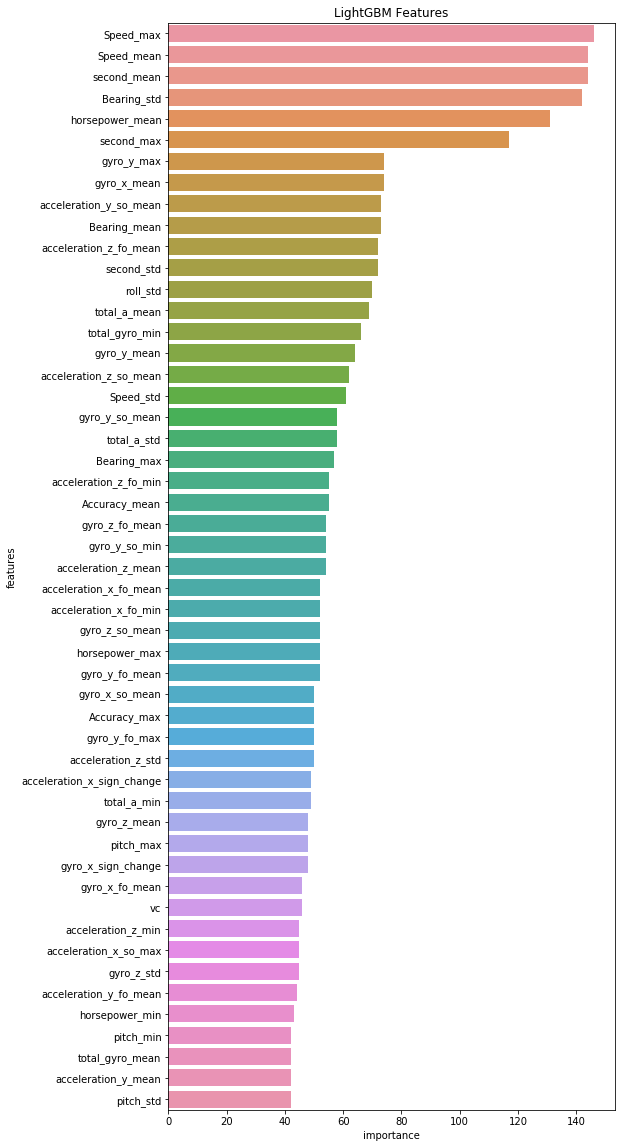

In [0]:
feature_score = lgb_clf.feature_importance()

features_df = pd.DataFrame({'features': features,
                            'importance': feature_score})

features_df = features_df.sort_values('importance', ascending=False)

features_df = features_df[:int(len(features)/2)]

plt.figure(figsize=(8,20))
sns.barplot(x="importance", y="features", 
            data=features_df)
plt.title('LightGBM Features')
plt.show()